# Computer vision - Disparity map

In [9]:
import numpy as np, matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.color import label2rgb
from skimage.filters.rank import entropy
from skimage import color, io, morphology, filters
from skimage.feature import graycomatrix, graycoprops
from skimage.segmentation import find_boundaries, mark_boundaries

We use an algorithm to search for corresponding pixels in images based on the similarity of their surroundings. For a small region (patch) in one image, we attempt to find the most similar patch in the second image. The patch that most closely resembles it is recorded (along with its displacement) in the disparity map.

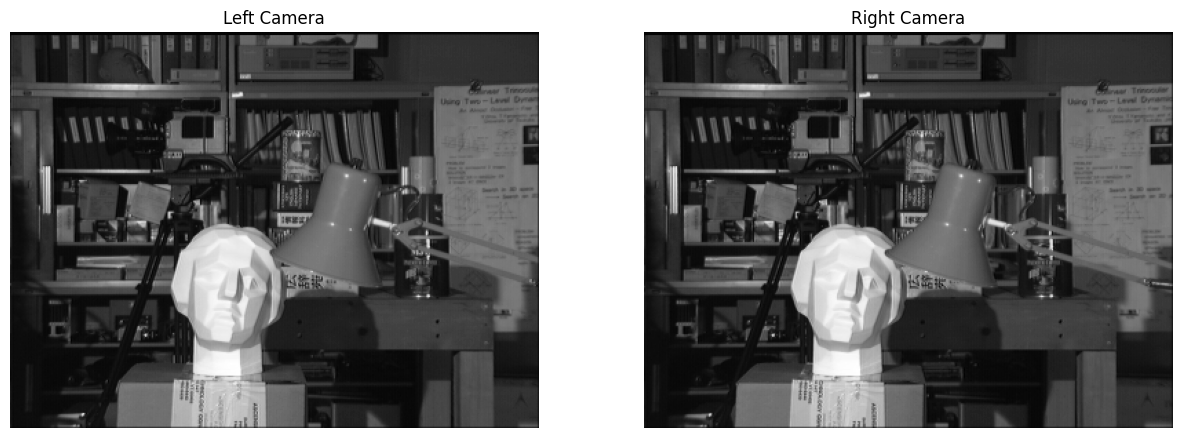

In [10]:
import matplotlib.pyplot as plt
from skimage import io, color

# Read the images
img_left = io.imread('example files/tsukubaleft.jpg')
img_right = io.imread('example files/tsukubaright.jpg')

# Display the original images
plt.figure(figsize=(15, 10))

# Plot for the left image
plt.subplot(121)
plt.title('Left Camera')
plt.imshow(img_left, cmap="gray")
plt.axis('off')  # Turn off axis labels for better visualization

# Plot for the right image
plt.subplot(122)
plt.title('Right Camera')
plt.imshow(img_right, cmap="gray")
plt.axis('off')  # Turn off axis labels for better visualization

plt.show()

# Further processing or analysis can be performed with img_left_gray and img_right_gray


## Setting up parameters

In [11]:
height, width = img_right.shape
dispMin = 0
dispMax = 16
windows_size = 9
dispMap = np.zeros((height, width))
w = windows_size // 2

For calculating the disparity map, various metrics can be employed, such as Euclidean distance, sum of absolute differences, sum of squared differences, or Hamming distance.

In [12]:
from tqdm import tqdm
import numpy as np

def disparity_map(mode, img_left, img_right, dispMap, w, dispMin, dispMax):
    """
    Compute the disparity map using block matching.

    Parameters:
    - mode: String, specifies the matching mode ("norm", "abs", "square", "hamming").
    - img_left: 2D array, the left stereo image.
    - img_right: 2D array, the right stereo image.
    - dispMap: 2D array, initialized disparity map to be filled.
    - w: Integer, half of the window size for block matching.
    - dispMin: Integer, minimum disparity value.
    - dispMax: Integer, maximum disparity value.

    Returns:
    - dispMap: 2D array, the computed disparity map.
    """

    # Get image dimensions
    height, width = img_left.shape

    # Loop over image rows
    for i in tqdm(range(w, height - w), 'Image processing'):
        # Loop over image columns within the valid disparity range
        for j in range(w, width - dispMax - w):
            # Initialize variables for minimum difference and corresponding position
            min_val = np.inf
            position = 0

            # Define the right window in the right image
            right_window = img_right[i - w:i + w, j - w:j + w]

            # Loop over the disparity range
            for k in range(dispMin, dispMax):
                # Define the left window in the left image, shifted by disparity k
                left_window = img_left[i - w:i + w, j - w + k:j + w + k]

                # Compute the difference based on the specified mode
                if mode == "norm":
                    dif = np.sum((left_window - right_window) ** 2) ** 0.5
                elif mode == "abs":
                    dif = np.sum(np.abs(left_window - right_window))
                elif mode == "square":
                    dif = np.sum((left_window - right_window) ** 2)
                elif mode == "hamming":
                    xor = np.bitwise_xor((right_window * 255).astype(np.uint8),
                                         (left_window * 255).astype(np.uint8))
                    bit_diff = np.unpackbits(xor)
                    dif = np.sum(bit_diff)

                # Update minimum difference and corresponding position
                if min_val > dif:
                    min_val = dif
                    position = k

            # Assign the disparity value to the disparity map at the current pixel
            dispMap[i, j] = position

    return dispMap


Image processing: 100%|███████████████████████| 280/280 [00:26<00:00, 10.58it/s]


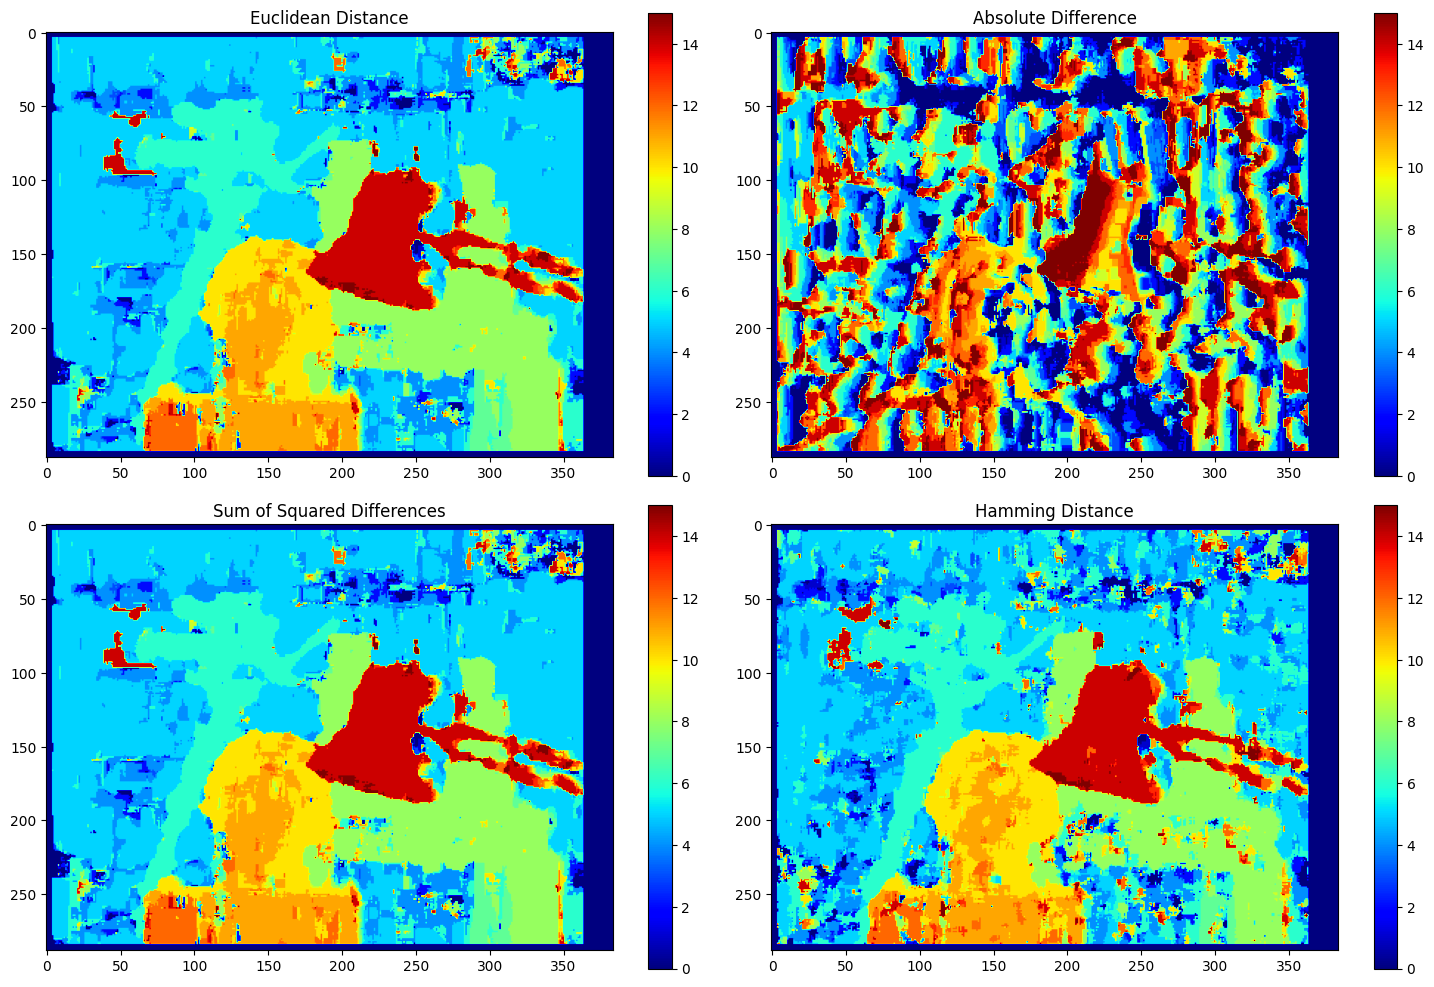

In [13]:
plt.figure(figsize=(15, 10))

# Euclidean Distance
plt.subplot(221)
plt.title("Euclidean Distance")
disparity_map_out = disparity_map("norm", img_left, img_right, dispMap, w, dispMin, dispMax)
plt.imshow(disparity_map_out, cmap='jet')  # Use 'viridis' colormap for depth perception
plt.colorbar()  # Add colorbar for reference

# Absolute Difference
plt.subplot(222)
plt.title("Absolute Difference")
disparity_map_out = disparity_map("abs", img_left, img_right, dispMap, w, dispMin, dispMax)
plt.imshow(disparity_map_out, cmap='jet')
plt.colorbar()

# Sum of Squared Differences
plt.subplot(223)
plt.title("Sum of Squared Differences")
disparity_map_out = disparity_map("square", img_left, img_right, dispMap, w, dispMin, dispMax)
plt.imshow(disparity_map_out, cmap='jet')
plt.colorbar()

# Hamming Distance
plt.subplot(224)
plt.title("Hamming Distance")
disparity_map_out = disparity_map("hamming", img_left, img_right, dispMap, w, dispMin, dispMax)
plt.imshow(disparity_map_out, cmap='jet')
plt.colorbar()

plt.tight_layout()
plt.show()


Image processing: 100%|███████████████████████| 274/274 [00:21<00:00, 12.77it/s]


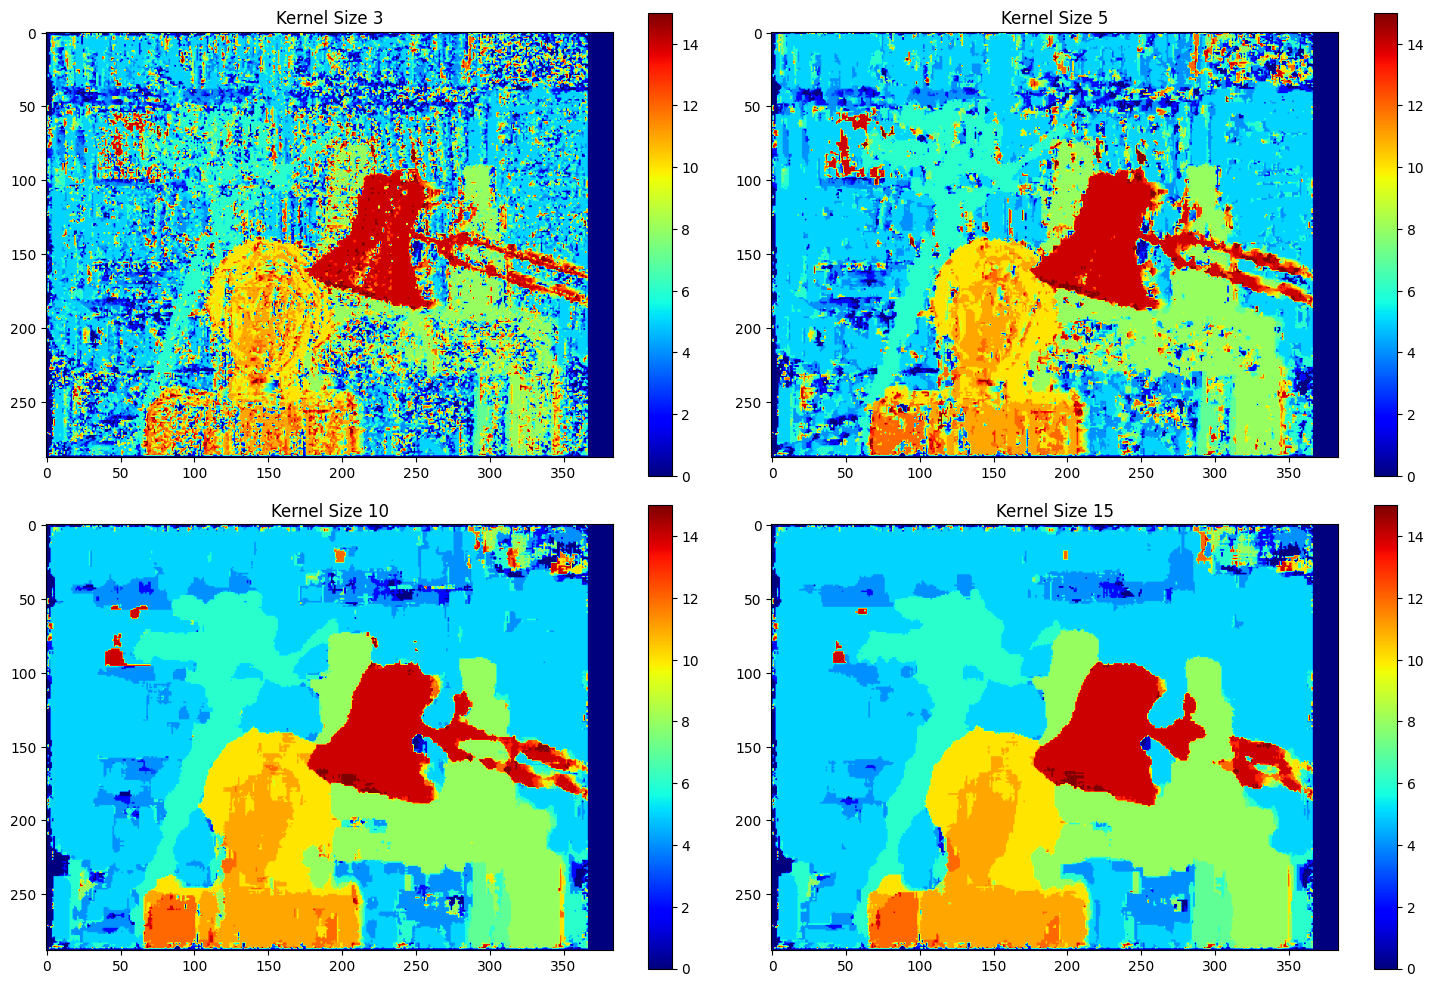

In [14]:
# Demonstrate with different kernel sizes
kernel_sizes = [3, 5, 10, 15]

plt.figure(figsize=(15, 10))

for i, kernel_size in enumerate(kernel_sizes, start=1):
    plt.subplot(2, 2, i)

    plt.title(f"Kernel Size {kernel_size}")
    w = kernel_size // 2
    # Compute disparity map using the specified kernel size

    disparity_map_out = disparity_map("norm", img_left, img_right, dispMap, w, dispMin, dispMax)

    # Display the disparity map
    plt.imshow(disparity_map_out, cmap='jet')
    plt.colorbar()

plt.tight_layout()
plt.show()

### Additional work ###
Try and implement your own metrics for block matching search - for example use the pattern search method used in the lab excercises on Convolution and Fourier transform. Remember that the method works well on high contrast images only, consider contrast enhancement of the blocks, canny edge detection, thresholding ...

Also, keep in mind: if you are a using difference measure - the lower the better, as above, or a similarity measure - the higher the better, as in convolution.